# Basic CIFAR-10 training
This tutorial will show a minimal example how to train Vision-LSTM on CIFAR-10 from scratch.
For simplicity, we omit speed and accuracy optimizations but note them in places where one would need to implement them.

The following speed optimizations are omitted:
- bfloat16 mixed precision training (this tutorial uses float32 because bfloat16 is not supported on colab T4 cards)
- `torch.compile` is not used because compiling the model takes a couple of minutes and might cause confusion thinking that the code crashed despite everything working as intended

The following accuracy optimizations are omitted:
- image augmentations (RandomResizedCrop, HorizontalFlip, ThreeAugment, Mixup, ...)
- a simple linear warmup -> linear decay schedule is used
- for optimal performance a longer training schedule would be needed (this tutorial uses 10 epochs)

In [1]:
!git clone https://github.com/NX-AI/vision-lstm
%cd vision-lstm

fatal: destination path 'vision-lstm' already exists and is not an empty directory.
/content/vision-lstm


In [2]:
!pip install einops

In [3]:
# general imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F

In [4]:
# initialize device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
print(device)

Tesla T4
cuda


In [5]:
# create model
from vision_lstm import VisionLSTM2
model = VisionLSTM2(
    dim=192,  # latent dimension (192 for ViL-T)
    depth=12,  # how many ViL blocks (1 block consists 2 subblocks of a forward and backward block)
    patch_size=4,  # patch_size (results in 64 patches for 32x32 images)
    input_shape=(3, 32, 32),  # RGB images with resolution 32x32
    output_shape=(10,),  # classifier with 10 classes
    drop_path_rate=0.0,  # stochastic depth parameter (disabled for ViL-T)
).to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")
print(model)

parameters: 5.8M
VisionLSTM2(
  (patch_embed): VitPatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_embed): VitPosEmbed2d()
  (blocks): ModuleList(
    (0-11): 12 x ViLBlockPair(
      (rowwise_from_top_left): ViLBlock(
        (drop_path): DropPath(drop_prob=0.000)
        (norm): LayerNorm()
        (layer): ViLLayer(
          (proj_up): Linear(in_features=192, out_features=768, bias=True)
          (q_proj): LinearHeadwiseExpand(dim=384, num_heads=96, bias=True, )
          (k_proj): LinearHeadwiseExpand(dim=384, num_heads=96, bias=True, )
          (v_proj): LinearHeadwiseExpand(dim=384, num_heads=96, bias=True, )
          (conv): SequenceConv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384)
          (mlstm_cell): MatrixLSTMCell(
            (igate): Linear(in_features=1152, out_features=4, bias=True)
            (fgate): Linear(in_features=1152, out_features=4, bias=True)
            (outnorm): MultiHeadLayerNorm()
  

In [6]:
# wrap in torch.compile to speedup training
# we recommend to use torch.compile, but it results in the first update step taking a couple of minutes
# which might cause confusion -> we disable it by default
# model = torch.compile(model)

In [7]:
# create dataset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
# datasets without augmentation for simplicity
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = CIFAR10(root="./data", train=False, download=False, transform=ToTensor())
print(f"train_dataset length: {len(train_dataset)}")
print(f"test_dataset length: {len(test_dataset)}")

Files already downloaded and verified
train_dataset length: 50000
test_dataset length: 10000


In [8]:
# hyperparameters
batch_size = 256
epochs = 10
lr = 1e-3
weight_decay = 0.05

In [9]:
# setup dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_updates = len(train_dataloader) * epochs
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat(
    [
        # linear warmup
        torch.linspace(0, optim.defaults["lr"], warmup_updates),
        # linear decay
        torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
    ],
)

# train model
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description("train_loss: ????? train_accuracy: ????% test_accuracy: ????%")
test_accuracy = 0.0
train_losses = []
train_accuracies = []
test_accuracies = []
loss = None
train_accuracy = None
for _ in range(epochs):
    # train for an epoch
    model.train()
    for x, y in train_dataloader:
        # prepare forward pass
        x = x.to(device)
        y = y.to(device)

        # schedule learning rate
        for param_group in optim.param_groups:
            param_group["lr"] = lrs[update]

        # forward pass (this tutorial doesnt use mixed precision because T4 cards dont support bfloat16)
        # we recommend bfloat16 mixed precision training
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        train_accuracy = ((y_hat.argmax(dim=1) == y).sum() / y.numel()).item()
        update += 1
        pbar.update()
        pbar.set_description(
            f"train_loss: {loss.item():.4f} "
            f"train_accuracy: {train_accuracy * 100:4.1f}% "
            f"test_accuracy: {test_accuracy * 100:4.1f}%"
        )
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)

    # evaluate
    num_correct = 0
    model.eval()
    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_hat = model(x)
            num_correct += (y_hat.argmax(dim=1) == y).sum().item()
    test_accuracy = num_correct / len(test_dataset)
    test_accuracies.append(test_accuracy)
    pbar.set_description(
        f"train_loss: {loss.item():.4f} "
        f"train_accuracy: {train_accuracy * 100:4.1f}% "
        f"test_accuracy: {test_accuracy * 100:4.1f}%"
    )
pbar.close()

  0%|          | 0/1950 [00:00<?, ?it/s]

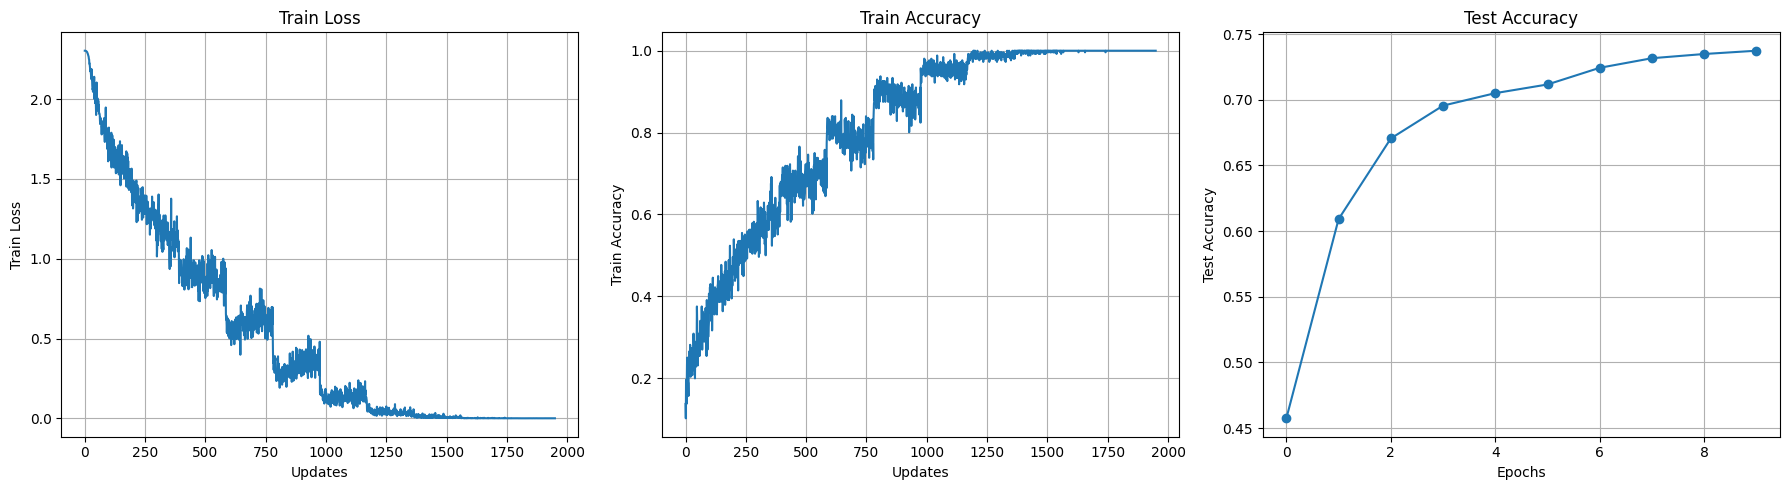

In [10]:
# plot training curves
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(range(len(train_losses)), train_losses)
axes[0].set_xlabel("Updates")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Train Loss")
axes[0].grid(True)
axes[1].plot(range(len(train_accuracies)), train_accuracies)
axes[1].set_xlabel("Updates")
axes[1].set_ylabel("Train Accuracy")
axes[1].set_title("Train Accuracy")
axes[1].grid(True)
axes[2].plot(range(len(test_accuracies)), test_accuracies, marker="o")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Test Accuracy")
axes[2].set_title("Test Accuracy")
axes[2].grid(True)
plt.tight_layout()
plt.show()


# Potential Issues
- `optim.step()` throws an error ([issue](https://github.com/NX-AI/vision-lstm/issues/16))
    - update your pytorch version
    - use SGD
    - remove lr scheduling (`for param_group in optim.param_groups: param_group["lr"] = lrs[update]`)